# Support Vector Regression Modelling

## The `housing` problem

We want to predict average house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, time
import sklearn as skl
import seaborn as sns

import gzip
import pickle

from sklearn.datasets import load_boston

## Data Loading

In [21]:
f = r'D:\GoogleDrive\Cursos\datasets\housing.csv'

boston_data = load_boston()

df_housing_raw = pd.DataFrame(data=boston_data['data'], columns=boston_data['feature_names'])
df_housing_raw['MEDV'] = boston_data['target']

print ("n_rows: %d\tn_columns: %d\n" % (df_housing_raw.shape[0], df_housing_raw.shape[1]) )
print ("columns:\t", list(df_housing_raw.columns))

n_rows: 506	n_columns: 14

columns:	 ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [22]:
df_housing_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.593761,8.596783,0.00632,0.082045,0.25651,3.647423,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


Remove the highest valued houses

In [23]:
idx_high_medv = df_housing_raw['MEDV'] < 50.

df_housing_filter = df_housing_raw.loc[ idx_high_medv ]

In [24]:
df_housing = df_housing_filter

vars_housing   = df_housing.columns[ : -1]
target_housing = df_housing.columns[-1]

## Support Vector Regression

Just getting started ...
Build a first Gaussian kernel model (to be hyperparameterized later).

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

mm_sc = MinMaxScaler((0, 1))

x = df_housing[ vars_housing ].values
x = mm_sc.fit_transform(df_housing[ vars_housing ].values)

y = df_housing[ target_housing ]

n_patterns, dim = x.shape

MAE: 3.775
num_svs:  401
num SVs at bound:  398


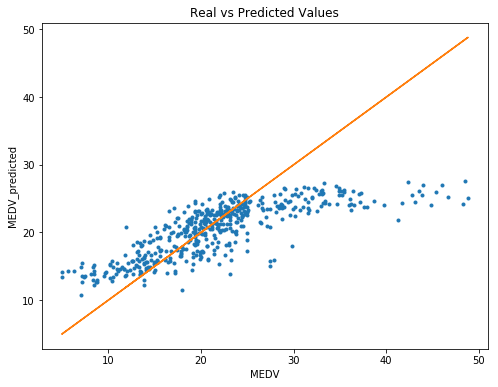

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#SVR hyperparams
C = 1.
dim = x.shape[1]
gamma = 1./dim
epsilon = y.std()/10.

svr_m =  SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)

#ajuste sobre la muestra completa, sin split train-test
svr_m.fit(x, y)
y_pred = svr_m.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))
print("num_svs: ", svr_m.support_vectors_.shape[0])
print("num SVs at bound: ", (abs(svr_m.dual_coef_) == C).sum())

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

Our first SVR model clearly underfits.

Can we make it to overfit?

Certainy: just

* Use a large $C$ to strongly penalize slacks
* Use a large $\gamma$ to get sharp Gaussians 
* Use a small $\epsilon$  so that any slack/error penalizes

MAE: 0.970
num_svs:  457
num SVs at bound:  279


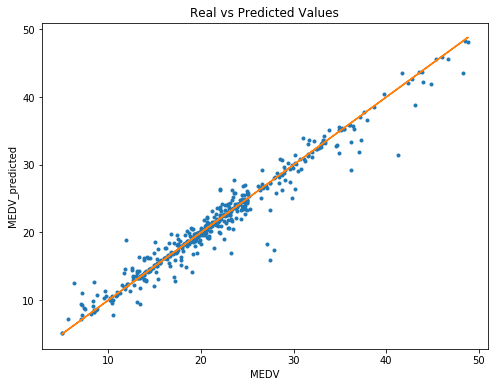

In [27]:
C = 100.
gamma = 16./dim
epsilon = y.std()/50.

svr_m =  SVR(C=C, gamma=gamma, epsilon=epsilon)

#ajuste sobre la muestra completa, sin split train-test
svr_m.fit(x, y)

y_pred = svr_m.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))
print("num_svs: ", svr_m.support_vectors_.shape[0])
print("num SVs at bound: ", (abs(svr_m.dual_coef_) == C).sum())

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Finding the optimal `C, gamma, epsilon` by CV

In [28]:
from sklearn.model_selection import GridSearchCV, KFold

# SVR hyperpars
svr_m = SVR(kernel='rbf', shrinking=True, tol=1.e-3, cache_size= 1000)
        
l_C       = [10.**k for k in range(-1, 4)] 
l_gamma   = list( np.array([4.**k for k in range(-1, 5)]) / dim )

l_epsilon = list( y.std() * np.array([2.**k for k in range(-5, 0)]) )

param_grid = {'C': l_C, 'gamma':l_gamma, 'epsilon':l_epsilon}

n_jobs = 2

n_folds = 10
kf = KFold(n_folds, shuffle=True)

scoring="neg_mean_absolute_error"

t_0 = time.time()
C_gamma_epsilon_search = GridSearchCV(svr_m, param_grid=param_grid, 
                                      cv=kf, scoring=scoring, 
                                      n_jobs=n_jobs, 
                                      return_train_score=True,
                                      verbose=True)
C_gamma_epsilon_search.fit(x, y)
print("GrdidSearchCV_time: %.f" % (time.time() - t_0))

f_pkl = open("svr_C_gamma_epsilon_cv_search_results_housing.pkl", 'wb') 
pickle.dump(C_gamma_epsilon_search, f_pkl)
f_pkl.close()

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Done  71 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 1379 tasks      | elapsed:   43.7s
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:   45.3s finished


GrdidSearchCV_time: 46


#### Recover grid search from pickle file, get best parameter values and evaluate them by 10 fold CV

In [11]:
f_pkl = open('svr_C_gamma_epsilon_cv_search_results_housing.pkl', mode='rb')
C_gamma_epsilon_search = pickle.load(f_pkl)
f_pkl.close()

raw_params: 100.0 1.2307692307692308 0.49158131643626607
normalized_params: 100.0 16.0 0.0625
MAE: 1.751
num_svs:  383
num SVs at bound:  220


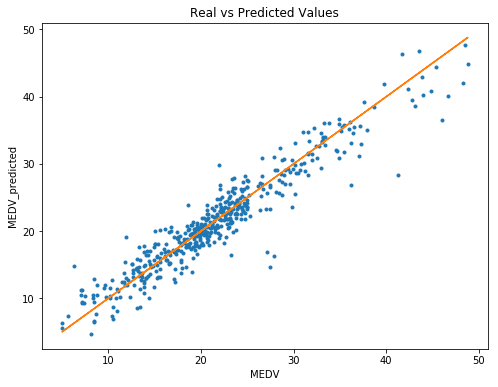

In [12]:
from sklearn.model_selection import cross_val_score, cross_val_predict

best_C       = C_gamma_epsilon_search.best_params_['C']
best_gamma   = C_gamma_epsilon_search.best_params_['gamma']
best_epsilon = C_gamma_epsilon_search.best_params_['epsilon']

print("raw_params:", best_C, best_gamma, best_epsilon)
print("normalized_params:", best_C, best_gamma*dim, best_epsilon/y.std())

svr_m =  SVR(C=best_C, gamma=best_gamma, epsilon=best_epsilon,
             kernel='rbf', shrinking=True, 
             tol=1.e-3, cache_size= 1000)

n_folds = 10
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(svr_m, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=n_jobs)

y_pred = cross_val_predict(svr_m, x, y, cv=kf, n_jobs=n_jobs)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))

svr_m.fit(x, y)
print("num_svs: ", svr_m.support_vectors_.shape[0])
print("num SVs at bound: ", (abs(svr_m.dual_coef_) == C).sum())

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

## Analyzing best hyperpars

Sort by best CV test score

In [13]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(C_gamma_epsilon_search.cv_results_)

df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_C', 'param_gamma', \
                                                                              'param_epsilon', 'mean_test_score']][ : 10]

,param_C,param_gamma,param_epsilon,mean_test_score
99,100,1.23077,0.491581,-1.733083
93,100,1.23077,0.245791,-1.754662
105,100,1.23077,0.983163,-1.763937
128,1000,0.307692,0.491581,-1.769217
134,1000,0.307692,0.983163,-1.771360
122,1000,0.307692,0.245791,-1.778025
140,1000,0.307692,1.96633,-1.800804
111,100,1.23077,1.96633,-1.824776
92,100,0.307692,0.245791,-1.893744
98,100,0.307692,0.491581,-1.898554


In [14]:
print('C: %.2f\tgamma: %.4f\tepsilon: %.4f' % 
      (best_C, best_gamma, best_epsilon))
print('best_cv_mae = %.3f' % (-C_gamma_epsilon_search.best_score_))


df_C_gamma_epsilon_search = pd.DataFrame.from_dict(C_gamma_epsilon_search.cv_results_)[['param_C', 'param_gamma',
                                                                                        'param_epsilon', 'mean_test_score']]

C: 100.00	gamma: 1.2308	epsilon: 0.4916
best_cv_mae = 1.733


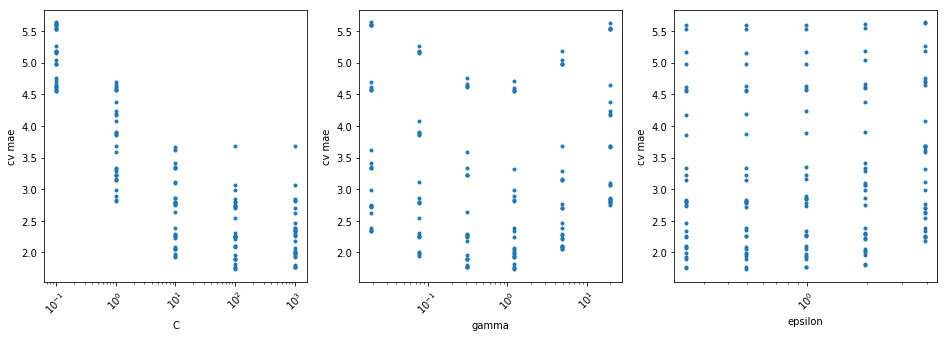

In [15]:
########## plotting hyperparameters by pairs
plt.figure( figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.xticks(range(len(l_C)), np.round(l_C, 2), rotation=45)
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.xticks(range(len(l_gamma)), np.round(np.array(l_gamma)*dim, 2), rotation=45)
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.xticks(range(len(l_epsilon)), np.round(np.array(l_epsilon)/y.std(), 3), rotation=45)
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

### C vs $\gamma$ plot

We plot a heatmap of $C$ vs $\gamma$ over the optimal $\epsilon$.

normalized_best_params: 100.0 16.0 0.0625


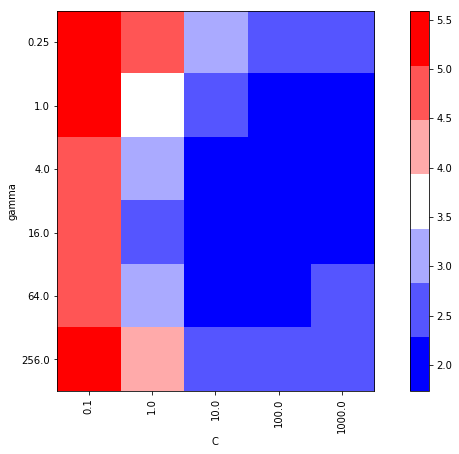

In [16]:
idx_best_eps = df_C_gamma_epsilon_search['param_epsilon'] == best_epsilon

m_t_s = -df_C_gamma_epsilon_search.loc[idx_best_eps].sort_values(by=['param_gamma', 'param_C'])['mean_test_score'].values.reshape(len(l_gamma), -1)

print("normalized_best_params:", best_C, best_gamma*dim, best_epsilon/y.std())

nticks_C = len(l_C)
nticks_gamma = len(l_gamma)

plt.figure( figsize=(13, 7) )

plt.xlabel('C')
plt.ylabel('gamma')

plt.xticks(range(nticks_C), l_C, rotation='vertical')
plt.yticks(range(nticks_gamma), np.array(l_gamma)*dim) 

cMap = plt.cm.get_cmap("bwr",lut=7) 

_ = plt.colorbar(plt.imshow(m_t_s, interpolation='nearest', cmap=cMap))
#_ = plt.colorbar(plt.imshow(m_t_s, interpolation='nearest', vmin=0.6, vmax=0.8, cmap=cMap))

plt.show()

### Testing the final model

raw_best_params: 100.0 1.2307692307692308 0.49158131643626607
normalized_best_params: 100.0 16.0 0.0625
mae_mean: 1.78	mae_std: 0.17

MAE: 1.784
num_svs:  383
num SVs at bound:  220


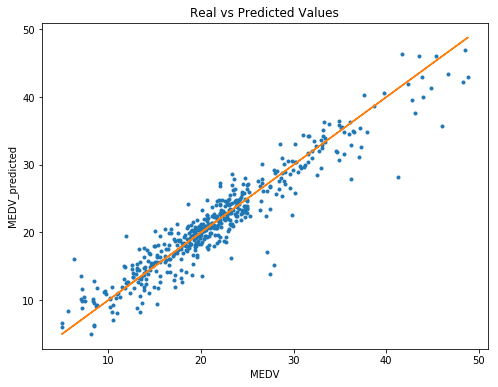

In [17]:
from sklearn.model_selection import cross_val_score, cross_val_predict

best_C       = C_gamma_epsilon_search.best_params_['C']
best_gamma   = C_gamma_epsilon_search.best_params_['gamma']
best_epsilon = C_gamma_epsilon_search.best_params_['epsilon']

print("raw_best_params:", best_C, best_gamma, best_epsilon)
print("normalized_best_params:", best_C, best_gamma*dim, best_epsilon/y.std())

svr_m =  SVR(C=best_C, gamma=best_gamma, epsilon=best_epsilon,
             kernel='rbf', shrinking=True, 
             tol=1.e-3, cache_size= 1000)

n_folds = 10
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(svr_m, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=n_jobs)
print("mae_mean: %.2f\tmae_std: %.2f" % (-scores.mean(), scores.std()))

y_pred = np.clip( cross_val_predict(svr_m, x, y, cv=kf, n_jobs=n_jobs), 5., 50.)
print("\nMAE: %.3f" % mean_absolute_error(y, y_pred))

svr_m.fit(x, y)
print("num_svs: ", svr_m.support_vectors_.shape[0])
print("num SVs at bound: ", (abs(svr_m.dual_coef_) == C).sum())

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

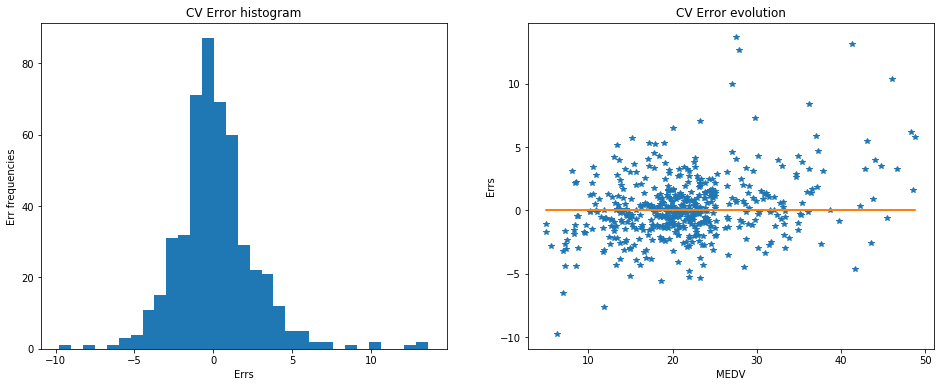

In [18]:
err = y - y_pred

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()